In [12]:
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import os 
%matplotlib inline

In [170]:


class RDF:
    """ percent is the percentage of the total number of nucleotides bewteen two species """
    def __init__(self, filename, resolution, percent):

        """ Molecular weights  """

        Hidrogen = 1.00784
        Oxigen = 15.999
        Nitrogen = 14.0067
        Carbon = 12.011
        Fosforo = 30.973762

        self.resolution = resolution
        self.percent = percent

        with open( filename ) as f:
            data = f.readlines()

        self.Ats_inf = []

        for line in range(len(data)):
            if 'ATOM' in data[line]:
                l_inf = data[line].split()[5]
                if l_inf == 'A' or l_inf == 'C' or l_inf == 'G' or l_inf == 'U':
                    self.Ats_inf.append(data[line])


        """ Total atoms number  """

        self.N_atoms = len(self.Ats_inf)


        """ Matrix with mass, nucleotide, residue, coordinates X, Y, Z """

        Matrix = np.zeros( ( self.N_atoms , 6 ) )

        """ Atomic weights are substituted by their numerical values,
                and nucleotides by 1234 """

        for j, line in enumerate( self.Ats_inf ):
            if  line.split()[2] == 'H':
                Matrix[j, 0] = Hidrogen
            elif  line.split()[2] == 'O':
                Matrix[j, 0] = Oxigen
            elif  line.split()[2] == 'N':
                Matrix[j, 0] = Nitrogen
            elif  line.split()[2] == 'C':
                Matrix[j, 0] = Carbon
            elif  line.split()[2] == 'P':
                Matrix[j, 0] = Fosforo
            else:
                print( 'Add atom ', line.split()[2] )

            if  line.split()[5] == 'A':
                Matrix[j, 1] = 1
            elif  line.split()[5] == 'C':
                Matrix[j, 1] = 2
            elif  line.split()[5] == 'G':
                Matrix[j, 1] = 3
            elif  line.split()[5] == 'U':
                Matrix[j, 1] = 4
            else:
                print(0)

            Matrix[j,2:] = [line.split()[8],
                    line.split()[10], line.split()[11],line.split()[12]]


        A = []
        C = []
        G = []
        U = []
        stack = []

        """ Compute the center of mass of each nuecleotide and store in ACGU lists. """
        
        l = 0
        for i in range(1, int(Matrix[self.N_atoms-1,2]) + 1):
            for j in range(len(Matrix)):
                if int(Matrix[j,2]) == i:
                    stack.append([Matrix[j,0], Matrix[j,3], Matrix[j,4], Matrix[j,5]])
                    ACGU = int(Matrix[j,1])

            if int(len(stack)) == 0:
                l = l + 1
            else:
                stack = np.array(stack)
                CM = self.CoM(stack)

                if ACGU == 1:
                    A.append([CM[0], CM[1], CM[2]])
                elif ACGU == 2:
                    C.append([CM[0], CM[1], CM[2]])
                elif ACGU == 3:
                    G.append([CM[0], CM[1], CM[2]])
                elif ACGU == 4:
                    U.append([CM[0], CM[1], CM[2]])
            stack = []
        
        """ List of nucleotides with their center of mass and the number of nucleotides by list """ 
        
        self.A = np.array(A)
        self.C = np.array(C)
        self.G = np.array(G)
        self.U = np.array(U)

        self.N_A = len(self.A)
        self.N_C = len(self.C)
        self.N_G = len(self.G)
        self.N_U = len(self.U)
        
        print( 'Total atoms number ' + filename , self.N_atoms)
        print( 'Number of nucleotides of species A: ', self.N_A )
        print( 'Number of nucleotides of species C: ', self.N_C )
        print( 'Number of nucleotides of species G: ', self.N_G )
        print( 'Number of nucleotides of species U: ', self.N_U )


    #########################################################################

    def CoM(self, stack):
        """ Comute the center of mass of an array of positions """

        M = np.sum(stack[:,0])
        X = 0
        Y = 0
        Z = 0
        for i in range(len(stack)):
            X += stack[i,0] * stack[i,1]
            Y += stack[i,0] * stack[i,2]
            Z += stack[i,0] * stack[i,3]
        return (X, Y, Z)/M



    def reduced_box( self, species_A, species_B , N_A , N_B , percent ):
        """ Reduce the size of the volume and the number of species in each volume """

        if int(percent) == 1:
            return species_A, species_B

        copyA = np.copy( species_A )
        copyB = np.copy( species_B )
        Iter_N = int( ( N_A + N_B ) * ( 1 - percent ) )

        for i in range( Iter_N ):
            SAmax = np.max( copyA )
            SBmax = np.max( copyB )
            SAmin = np.min( copyA )
            SBmin = np.min( copyB )

            Max_value =  max( abs( max(  SAmax , SBmax ) ), abs( min(  SAmin , SBmin ) ) )
            #print(Max_value)

            if Max_value == abs( SAmax ):
                index = np.where( copyA == SAmax )[0][0]
                copyA = np.delete( copyA , index , axis = 0)
            elif Max_value == abs( SBmax ):
                index =  np.where( copyB == SBmax )[0][0]
                copyB = np.delete( copyB , index , axis = 0)
            elif Max_value == abs( SAmin ):
                index =  np.where( copyA == SAmin )[0][0]
                copyA = np.delete( copyA , index , axis = 0)
            else:
                index = np.where( copyB == SBmin)[0][0]
                copyB = np.delete( copyB , index, axis = 0)

        print( len(copyA), len(copyB) )

        return copyA, copyB



    def Atoms_data(self, Atoms_inf, Atoms_filename):
        """ Creates a document .ciff with the information of the atoms """

        with open( Atoms_filename + '_raw.cif','w') as g:
            for line in Atoms_inf:
                g.write(line)

    def distance(self, a, b):
        """ Computes distance according to X_max, Y_max y Z_max  """

        dx = abs(a[0] - b[0])
        x = min(dx, abs(self.X_max - dx))

        dy = abs(a[1] - b[1])
        y = min(dy, abs(self.Y_max - dy))

        dz = abs(a[2] - b[2])
        z = min(dz, abs(self.Z_max - dz))

        return np.sqrt(x**2 + y**2 + z**2)

    def density_number(self, N_A, N_B):
        """ Computes density number """
        
        dn = (N_A * N_B) /(self.X_max * self.Y_max * self.Z_max)
        return dn

    def volume(self, r):
        """ Computes volume """

        volume = ( 4.0 * sp.pi * r**3) / 3.0
        return volume

    def WCpairs(self, specie_ab):
        if specie_ab == 'AU':
            print('Computing rdf between species AU...')
            radii_ab, rdf_ab = self.compute_rdf(self.A, self.U, self.N_A, self.N_U, self.resolution, self.percent)
        elif specie_ab == 'GC':
            print('Computing rdf between species GC...')
            radii_ab, rdf_ab = self.compute_rdf( self.G, self.C, self.N_G, self.N_C, self.resolution, self.percent)
        else:
            print('Not valid pairs')
            rdf_ab = 0
        return radii_ab, rdf_ab


    def compute_rdf(self, Species_A, Species_B, N_A, N_B, resolution, percent):
        """ Compute rdf for two species and return radii and rdf """

        Species_A, Species_B = self.reduced_box(Species_A, Species_B, N_A, N_B, percent)

        Concatenate = np.concatenate( ( Species_A, Species_B ) )

        Max_pos = np.amax( Concatenate, axis = 0 )
        Min_pos = np.amin( Concatenate, axis = 0 )

        self.X_max = Max_pos[0] - Min_pos[0]
        self.Y_max = Max_pos[1] - Min_pos[1]
        self.Z_max = Max_pos[2] - Min_pos[2]

        #print(self.X_max, self.Y_max, self.Z_max)

        self.resolution = resolution
        
        N_A = len(Species_A)
        N_B = len(Species_B)

        N_species = N_A  +  N_B 

        r_cutoff =  16 #min( min(self.X_max, self.Y_max ), self.Z_max ) / 2.0
        dr = r_cutoff / self.resolution
        volumes = np.zeros(self.resolution)

        self.radii = np.linspace(0.0, self.resolution * dr, self.resolution)
        self.rdf = np.zeros((int(len(Species_A)), self.resolution))


        for i, part_1 in enumerate(Species_A):

            for j, part_2 in enumerate(Species_B):

                dist = self.distance(part_1, part_2)
                index = int(dist / dr)
                if 0 < index < self.resolution:
                    self.rdf[i,index] += 2.0

        for j in range(self.resolution):
            r1 = j*dr
            r2 = r1 + dr
            v1 = self.volume( r1 )
            v2 = self.volume( r2 )
            volumes[j] += v2 - v1   

        self.rdf = np.mean(self.rdf, axis = 0)
        
        self.rdf = self.rdf / N_species

        for i, value in enumerate(self.rdf):
            self.rdf[i] = value/ (volumes[i] * self.density_number(N_A,N_B))

        return self.radii, self.rdf

    def plot_rdf(self, specie_ab, filename):
        """ Plot the rdf between two species and saves the file """

        rad, rdff = self.WCpairs( specie_ab )

        plt.xlabel( 'r (Å)')
        plt.ylabel(  'g(r)' )

        plt.plot(rad, rdff, label = specie_ab)
        plt.legend()
        plt.savefig( 'rdf_' + filename + '_' +  specie_ab + '.png' , dpi= self.resolution, bbox_inches='tight')
        plt.show()

    def plot_rdf_3d(self, species_ab, filename):
        
        """ Plots the center of mass of the nucleotides in 3d """

        if species_ab == 'AU':
            species_A = self.A
            species_B = self.U
        elif species_ab == 'GC':
            species_A = self.G
            species_B = self.C
        else:
            return print('Not valid pairs')


        X_1 = species_A[:,0]
        Y_1 = species_A[:,1]
        Z_1 = species_A[:,2]

        X_2 = species_B[:,0]
        Y_2 = species_B[:,1]
        Z_2 = species_B[:,2]

        fig3d = plt.figure( figsize = ( 10, 10) )
        ax = plt. axes( projection = '3d')
        ax.grid()

        ax.scatter( X_1, Y_1, Z_1, c = 'r', s = 50)
        ax.scatter( X_2, Y_2, Z_2, c = 'b', s = 50)
        ax.set_title( 'Nucleotidos ' + species_ab )

        ax.set_xlabel('x', labelpad = 20)
        ax.set_ylabel('y', labelpad = 20)
        ax.set_zlabel('z', labelpad = 20)

        
        plt.savefig('rdf_' + filename + '_' + species_ab + '_3d' + '.png')
        plt.show()




# Radial distribution function for pairs AU and GC with percent of nucleotides = 1


Total atoms number 6awc.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides of species U:  290
Computing rdf between species AU...


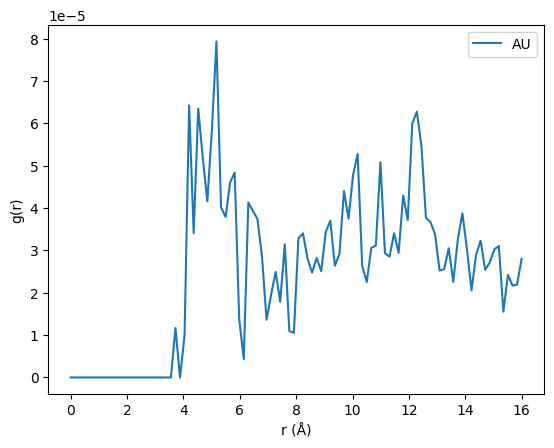

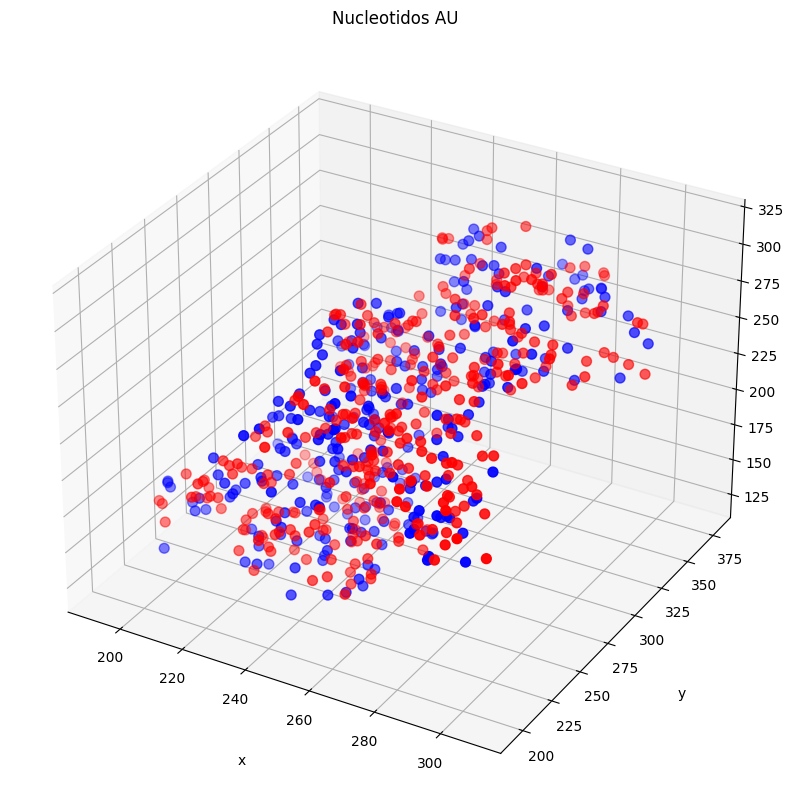

Computing rdf between species GC...


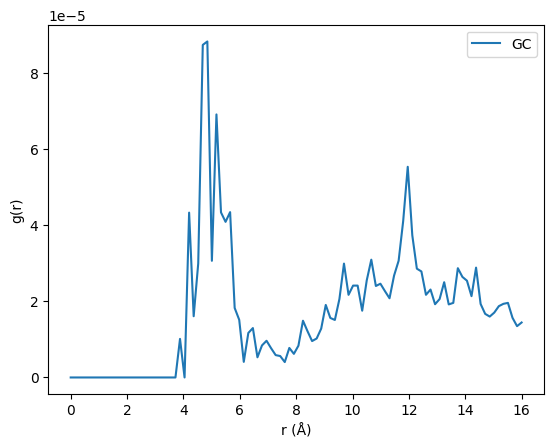

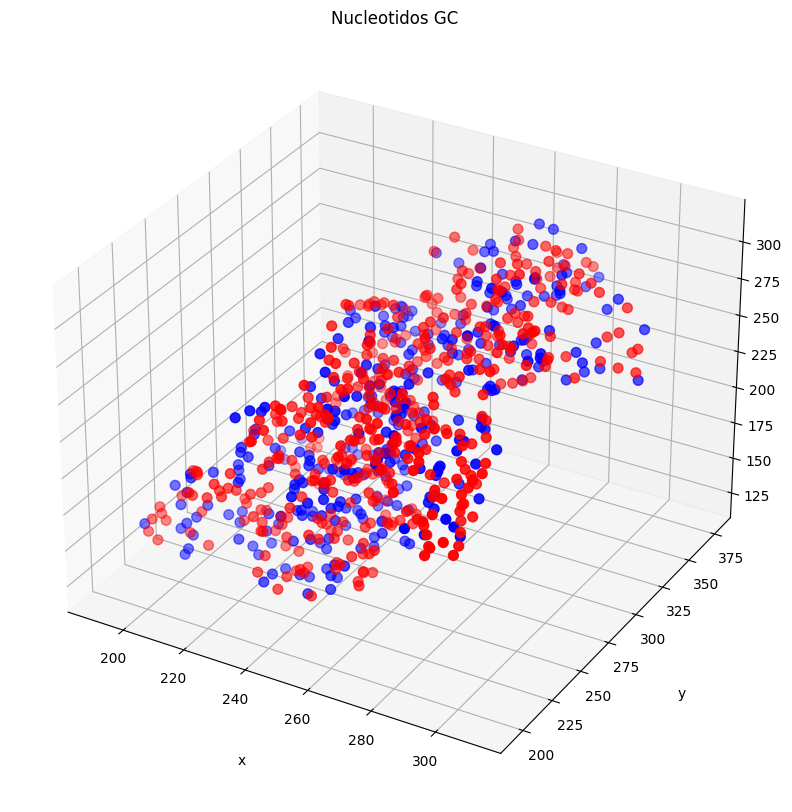

In [171]:
GR = RDF('6awc.cif', 100, 1)

GR.plot_rdf('AU', '6awc')
GR.plot_rdf_3d('AU', '6awc')
GR.plot_rdf('GC', '6awc')
GR.plot_rdf_3d('GC', '6awc')


# Radial distribution function for pairs AU and GC with percent of nucleotides = 0.8

Total atoms number 6awc.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides of species U:  290
Computing rdf between species AU...
290 235


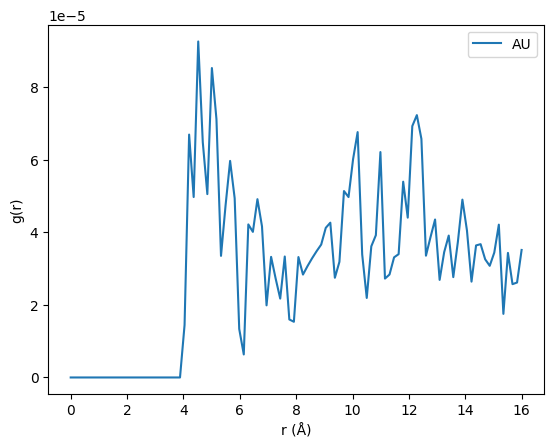

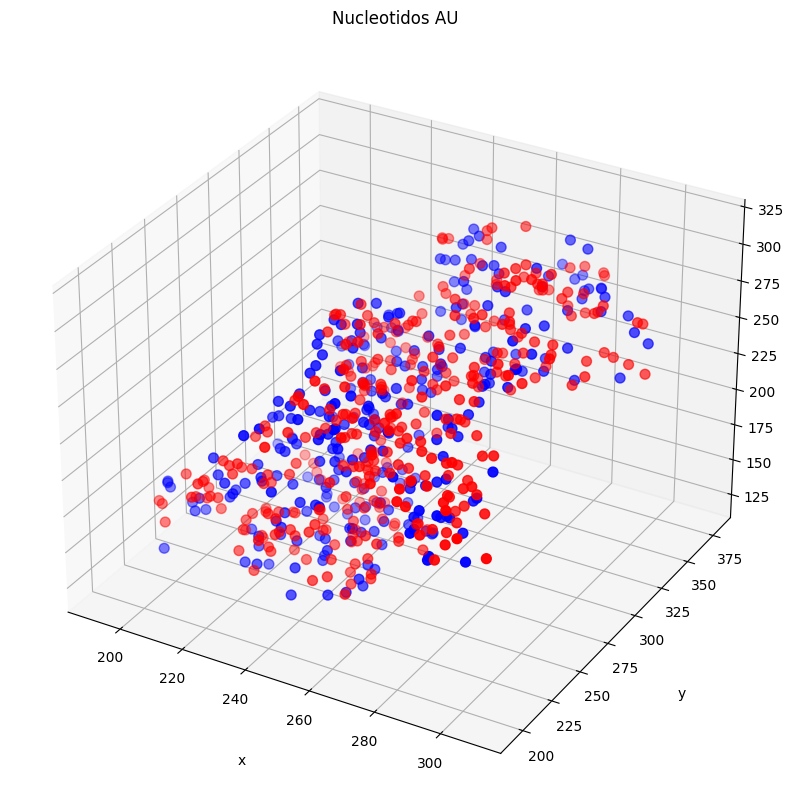

Computing rdf between species GC...
360 271


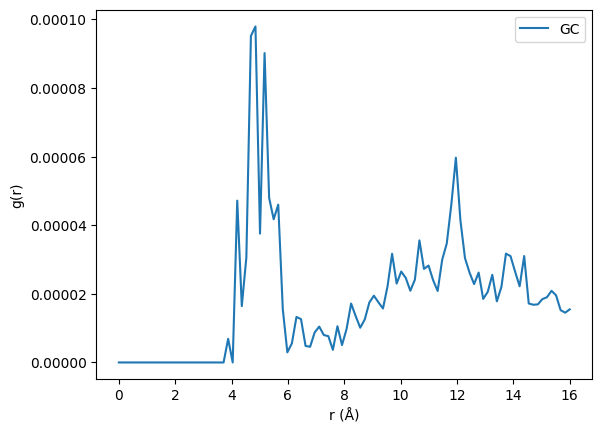

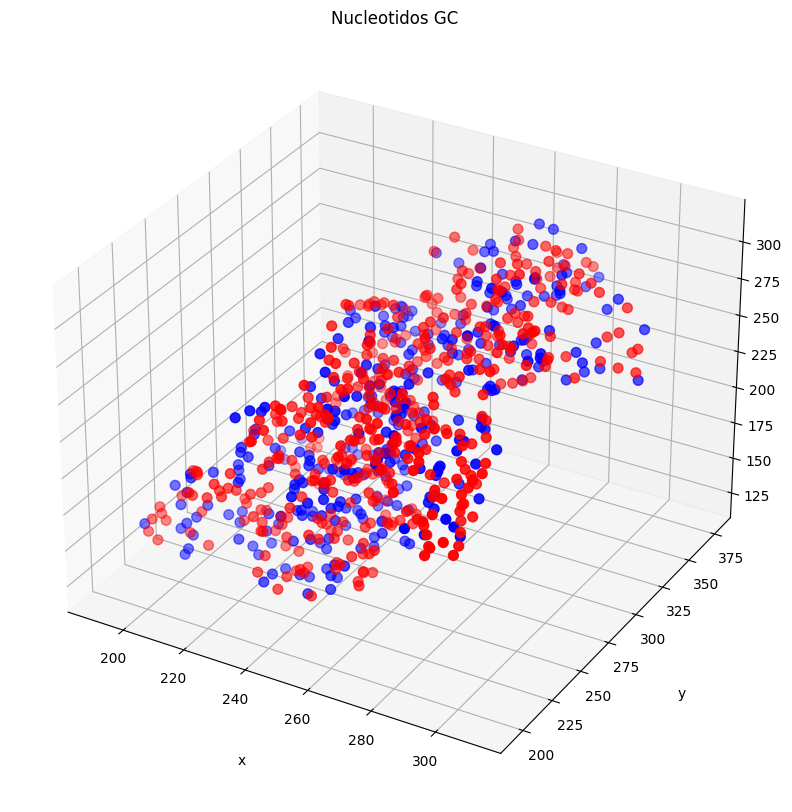

In [155]:
GR = RDF('6awc.cif', 100, 0.8)

GR.plot_rdf('AU', '6awc')
GR.plot_rdf_3d('AU', '6awc')
GR.plot_rdf('GC', '6awc')
GR.plot_rdf_3d('GC', '6awc')

In [159]:

def RDFaverage(path, res, percent):
    
    file_names = os.listdir(path)
    RDF_list_AU = np.zeros((10,res))
    RDF_list_GC = np.zeros((10,res))
    
    for i, filename in enumerate(file_names):
        if filename == '.ipynb_checkpoints':
            continue
        RDFF = RDF(path + "/"+ filename, res, percent)
        Raddi_and_RDF_AU = RDFF.WCpairs('AU')
        Raddi_and_RDF_GC = RDFF.WCpairs('GC')
        
        RDF_list_AU[i-1,:] = Raddi_and_RDF_AU[:][1]
        RDF_list_GC[i-1,:] = Raddi_and_RDF_GC[:][1]
        
    return RDF_list_AU, RDF_list_GC
    
def plotaverage(RDFlist, res, pairs):

    
    dr = 16/100
    RDF_mean = np.mean( RDFlist, axis = 0 )            
    radio = np.linspace(0.0, res * dr, res)


    plt.xlabel( 'r (Å)')
    plt.ylabel(  'g(r)' )

    plt.plot(radio, RDF_mean, label = pairs)
    plt.legend()
    plt.savefig( 'RDF_promedio' + pairs +'.png' , dpi=res, bbox_inches='tight')
    plt.show()
    
def BU(RDFlist, res, pairs):
    
    RDF_mean = np.mean( RDFlist, axis = 0 )
    
    radio = np.linspace(0.0, res * dr, res)
    
    indexx = np.where(RDF_mean > 0)[0][0]
    potential = -np.log(RDF_mean[indexx+1:])
    
    minimum = np.min(potential[20:])
    
    
    
    plt.axhline(y = minimum, color = 'r', linestyle = '-')

    plt.xlabel( 'r (Å)')
    plt.ylabel(  '$B$ u(r)' )

    plt.plot(radio[indexx+1:], potential, label = pairs)
    plt.legend()
    plt.savefig( 'potential_'+ pairs + '.png' , dpi=res, bbox_inches='tight')
    plt.show()

In [157]:
input_data = "/home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna"

RDF_list_AU, RDF_list_GC = RDFaverage(input_data, 100, 1)

Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/4adv.cif 30262
Number of nucleotides of species A:  356
Number of nucleotides of species C:  321
Number of nucleotides of species G:  450
Number of nucleotides of species U:  283
Computing rdf between species AU...
Computing rdf between species GC...
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awb.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides of species U:  290
Computing rdf between species AU...
Computing rdf between species GC...
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awc.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides of species U:  290
Comp

# Average RDF AU and GC with percent of nucleotides = 1 .

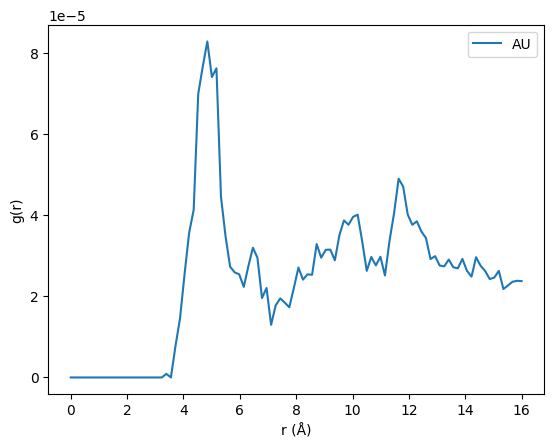

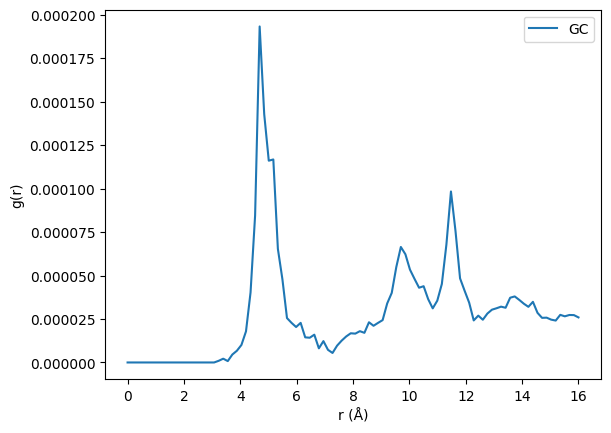

In [158]:

plotaverage(RDF_list_AU, 100, 'AU')
plotaverage(RDF_list_GC, 100, 'GC')


# Average potential AU and GC with percent of nucleotides = 1 .

/tmp/ipykernel_29218/3875927691.py:42: RuntimeWarning: divide by zero encountered in log
  potential = -np.log(RDF_mean[indexx+1:])


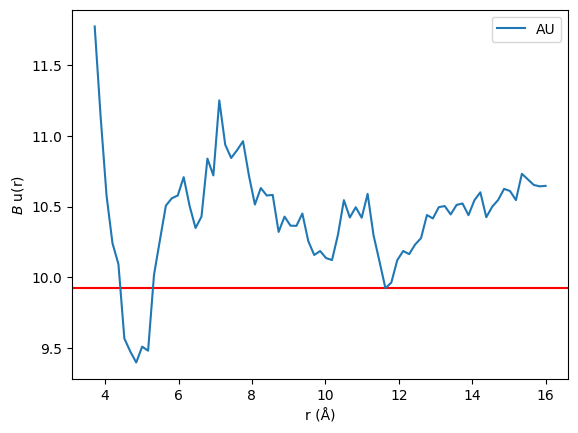

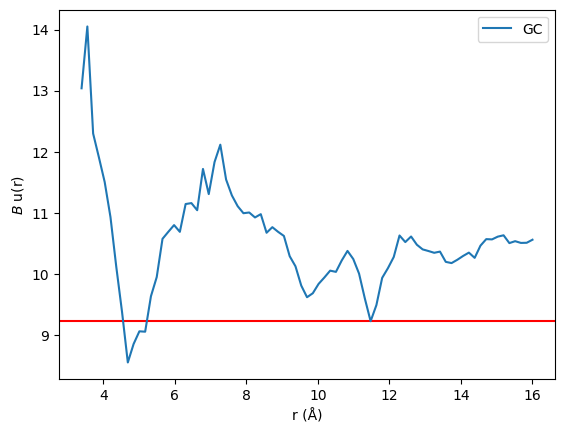

In [160]:
BU(RDF_list_AU, 100, 'AU')
BU(RDF_list_GC, 100, 'GC')

# Average RDF CG with percent of nucleotides = 0.8

In [161]:
input_data = "/home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna"

RDF_list_AU2, RDF_list_GC2 = RDFaverage(input_data, 100, 0.8)

Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/4adv.cif 30262
Number of nucleotides of species A:  356
Number of nucleotides of species C:  321
Number of nucleotides of species G:  450
Number of nucleotides of species U:  283
Computing rdf between species AU...
284 228
Computing rdf between species GC...
360 257
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awb.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides of species U:  290
Computing rdf between species AU...
290 235
Computing rdf between species GC...
360 271
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awc.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nuc

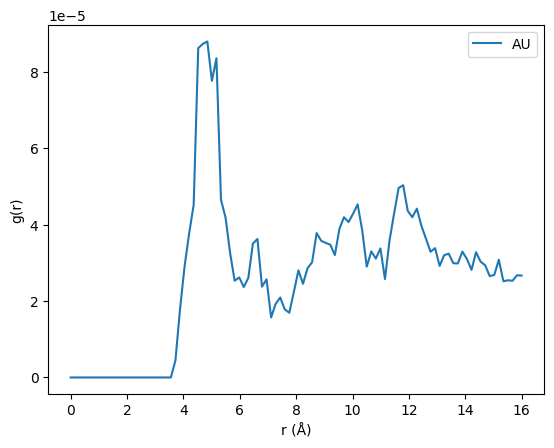

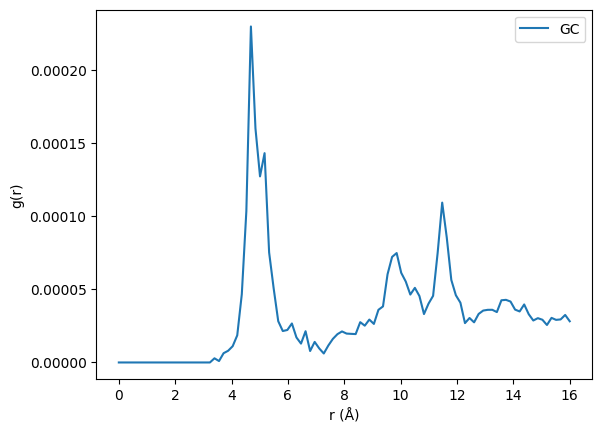

In [164]:
plotaverage(RDF_list_AU2, 100, 'AU')
plotaverage(RDF_list_GC2, 100, 'GC')

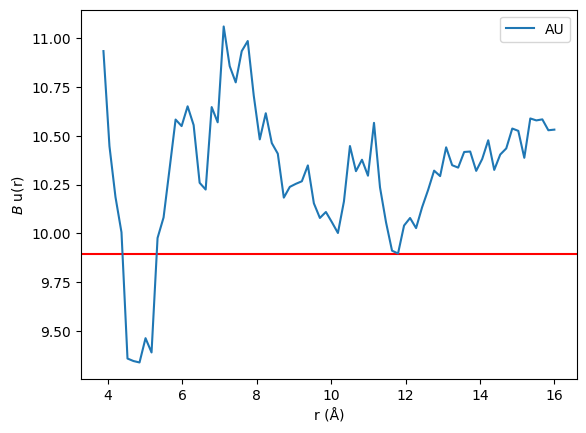

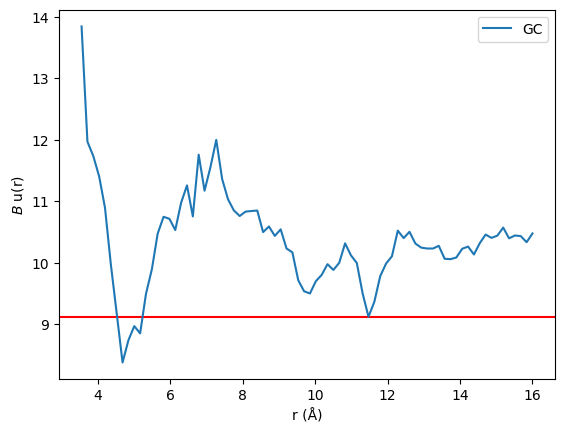

In [165]:
BU(RDF_list_AU2, 100, 'AU')
BU(RDF_list_GC2, 100, 'GC')

# Average RDF CG with percent of nucleotides = 0.5

In [167]:
input_data = "/home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna"

RDF_list_AU3, RDF_list_GC3 = RDFaverage(input_data, 100, 0.5)

Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/4adv.cif 30262
Number of nucleotides of species A:  356
Number of nucleotides of species C:  321
Number of nucleotides of species G:  450
Number of nucleotides of species U:  283
Computing rdf between species AU...
180 140
Computing rdf between species GC...
220 166
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awb.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides of species U:  290
Computing rdf between species AU...
179 149
Computing rdf between species GC...
223 171
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awc.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nuc

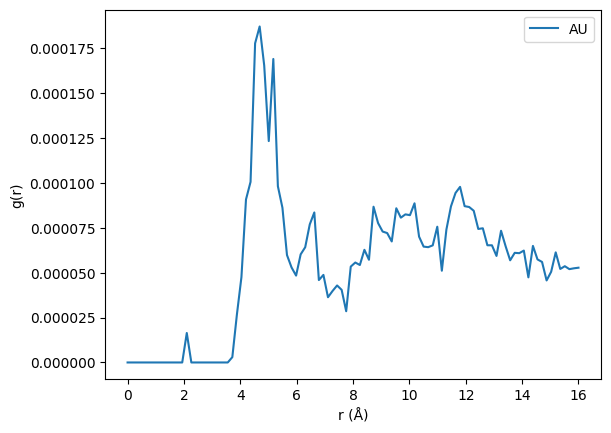

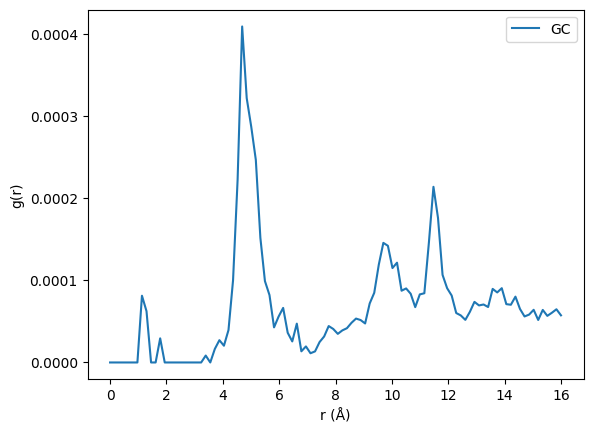

In [168]:
plotaverage(RDF_list_AU3, 100, 'AU')
plotaverage(RDF_list_GC3, 100, 'GC')

/tmp/ipykernel_29218/3875927691.py:42: RuntimeWarning: divide by zero encountered in log
  potential = -np.log(RDF_mean[indexx+1:])


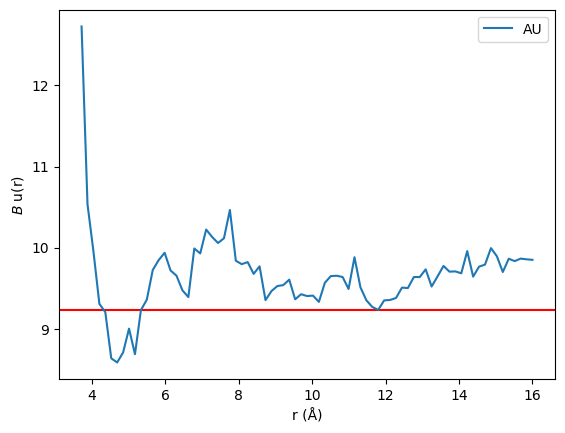

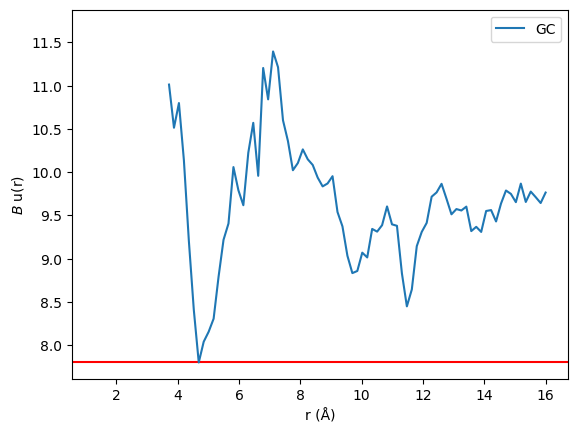

In [169]:
BU(RDF_list_AU3, 100, 'AU')
BU(RDF_list_GC3, 100, 'GC')

# Average RDF CG with percent of nucleotides = 0.5

In [172]:
input_data = "/home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna"

RDF_list_AU3, RDF_list_GC3 = RDFaverage(input_data, 100, 0.2)

Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/4adv.cif 30262
Number of nucleotides of species A:  356
Number of nucleotides of species C:  321
Number of nucleotides of species G:  450
Number of nucleotides of species U:  283
Computing rdf between species AU...
68 60
Computing rdf between species GC...
84 71
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awb.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides of species U:  290
Computing rdf between species AU...
68 63
Computing rdf between species GC...
83 75
Total atoms number /home/israelgr/Python_course/Statistical-Mechanics/On working/Proyecto/Ribosomal _rna/6awc.cif 30955
Number of nucleotides of species A:  365
Number of nucleotides of species C:  332
Number of nucleotides of species G:  456
Number of nucleotides